### Import

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

Dataset設定與前處理：

In [2]:
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
nb_classes=10
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# X_train 切出 X_train, X_val
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1001, stratify=y_train)
print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)
print(y_train[:10])

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(48000, 28, 28) (12000, 28, 28) (10000, 28, 28)
(48000,) (12000,) (10000,)
[2 0 0 4 3 3 7 5 7 7]


In [3]:
print(X_train.dtype)
print(X_train.shape)
print(X_train[ 0,:10, :10])

uint8
(48000, 28, 28)
[[  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 123]
 [  0   0   0   0   0   0   0   0   0 214]
 [  0   0   0   0   0   0   0   0   0 214]
 [  0   0   0   0   0   0   0   0  70 243]
 [  0   0   0   0   0   0   0   0  94 253]]


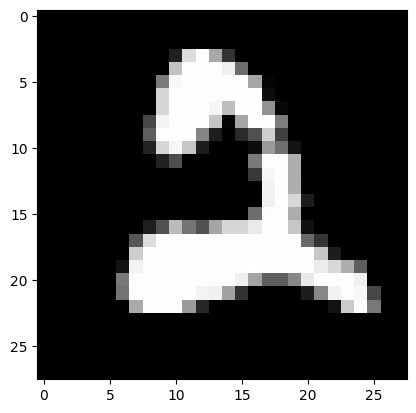

Label:  2


In [4]:
plt.imshow(X_train[0], cmap="gray")    # show first number in the dataset
plt.show()
print('Label: ', y_train[0])

In [5]:
X_train = np.expand_dims(X_train, axis=-1)
X_train.shape

(48000, 28, 28, 1)

In [6]:
X_val = np.expand_dims(X_val, axis=-1)
X_val.shape

(12000, 28, 28, 1)

In [7]:
X_test = np.expand_dims(X_test, axis=-1)
X_test.shape

(10000, 28, 28, 1)

In [8]:
# Convert to tf.data.Dataset.from_tensor_slices
X_train = tf.data.Dataset.from_tensor_slices(X_train)
X_val = tf.data.Dataset.from_tensor_slices(X_val)
X_test = tf.data.Dataset.from_tensor_slices(X_test)
y_train = tf.data.Dataset.from_tensor_slices(y_train.reshape(-1)) # reshape(-1): 2-d to 1-d
y_val = tf.data.Dataset.from_tensor_slices(y_val.reshape(-1))
y_test = tf.data.Dataset.from_tensor_slices(y_test.reshape(-1))

In [9]:
# Convert to tf.data.Dataset.zip
train_data = tf.data.Dataset.zip({"x": X_train, "y": y_train})
val_data = tf.data.Dataset.zip({"x": X_val, "y": y_val})
test_data = tf.data.Dataset.zip({"x": X_test, "y": y_test})

In [10]:
print(train_data)

<_ZipDataset element_spec={'x': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'y': TensorSpec(shape=(), dtype=tf.uint8, name=None)}>


In [11]:
# 影像資料：將輸入資料做標準化，全部除以255，將像素值縮放到0~1之間。
# 標籤資料：做One-hot Encoding，例如類別2為[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]。

def parse_fn(dataset):
    x = tf.cast(dataset['x'], tf.float32) / 255. # casts a tensor to new type
    y = tf.one_hot(dataset['y'], nb_classes) # one-hot
    return x, y

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # 自動調整模式
batch_size = 64  # 批次大小

train_data = train_data.shuffle(buffer_size=10000)  # 打散資料集
# 載入前面的資料愈處理function，cpu數量為自動調整模式
train_data = train_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# 載入前面的資料愈處理function，cpu數量為自動調整模式
val_data = val_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
val_data = val_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# 載入前面的資料愈處理function，cpu數量為自動調整模式
test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

### 訓練Model-1（全連接神經網路）

建立網路模型，這邊使用到以下幾種網路層：

keras.Input：輸入層(輸入影像大小為28x28x1)
layers.Flatten：扁平層(特徵圖轉成一維Tensor)
layers.Dropout：Dropout層(每次訓練隨機丟棄30%網路)
layers.Dense：全連接層(隱藏層使用ReLU激活函數，輸出層使用Softmax激活函數)

In [13]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Flatten()(inputs)

In [14]:
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)

In [15]:
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

In [16]:
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)

In [17]:
outputs = layers.Dense(10, activation='softmax')(x)
# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_1 = keras.Model(inputs, outputs, name='model-1')
model_1.summary()  # 顯示網路架構

Model: "model-1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,602 (588.29 KB)

 Trainable params: 150,602 (588.29 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model_dir = 'lab3-2-logs/models'  # 設定儲存權重目錄
os.makedirs(model_dir)  # 創建儲存權重目錄

In [21]:
# 將訓練記錄，存成TensorBoard的紀錄檔
log_dir = os.path.join('lab3-2-logs', 'model-1')
os.makedirs(log_dir, exist_ok=True)
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
output_model_file = os.path.join(model_dir,"Best-model-1.keras")
model_mckp = keras.callbacks.ModelCheckpoint(output_model_file,monitor='val_categorical_accuracy',
                                save_best_only=True,
                                mode='max')

In [22]:
model_1.compile(keras.optimizers.Adam(),
               loss=keras.losses.CategoricalCrossentropy(),
               metrics=[keras.metrics.CategoricalAccuracy()])

In [23]:
history_1 = model_1.fit(train_data,
                        validation_data=val_data,
                        epochs=100,
                        callbacks=[model_cbk, model_mckp])

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - categorical_accuracy: 0.7272 - loss: 0.8410 - val_categorical_accuracy: 0.9474 - val_loss: 0.1722
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - categorical_accuracy: 0.9318 - loss: 0.2441 - val_categorical_accuracy: 0.9621 - val_loss: 0.1278
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - categorical_accuracy: 0.9474 - loss: 0.1851 - val_categorical_accuracy: 0.9647 - val_loss: 0.1197
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - categorical_accuracy: 0.9550 - loss: 0.1544 - val_categorical_accuracy: 0.9682 - val_loss: 0.1069
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - categorical_accuracy: 0.9600 - loss: 0.1438 - val_categorical_accuracy: 0.9696 - val_loss: 0.1047
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - categorical_accuracy: 0.9639 - loss: 0.1215 - val_categorical_accuracy: 0.9748 - val_loss: 0.0890
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - categorical_accuracy: 0.96

In [24]:
loss, acc = model_1.evaluate(test_data) # the last fit result, not the best fit result
print('\nModel-1 Accuracy: {}%'.format(acc))

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - categorical_accuracy: 0.9730 - loss: 0.1604

Model-1 Accuracy: 0.9776999950408936%


### 訓練Model-2（卷積神經網路）

建立網路模型，這邊使用到以下幾種網路層：
- keras.Input：輸入層(輸入影像大小為28x28x1)
- layers.Conv2D：卷積層(使用ReLU激活函數，以及3x3大小的kernel)
- layers.MaxPool2D：池化層(對特徵圖下採樣)
- layers.Flatten：扁平層(特徵圖轉成一維Tensor)
- layers.Dropout：Dropout層(每次訓練隨機丟棄50%網路)
- layers.Dense：全連接層(隱藏層使用ReLU激活函數，輸出層使用Softmax激活函數)

In [14]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPool2D()(x) # 2x2,  stride=2
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)
# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_2 = keras.Model(inputs, outputs, name='model-2')
model_2.summary()  # 顯示網路架構

Model: "model-2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 9, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 5, 5, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 841,610 (3.21 MB)

 Trainable params: 841,610 (3.21 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# 儲存訓練記錄檔
log_dir = os.path.join('lab3-2-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
output_model_file = os.path.join(model_dir,"Best-model-2.keras")
model_mckp = keras.callbacks.ModelCheckpoint(output_model_file,
                                             monitor='val_categorical_accuracy',
                                             save_best_only=True,
                                             mode='max')

In [16]:
model_2.compile(keras.optimizers.Adam(),
               loss=keras.losses.CategoricalCrossentropy(),
               metrics=[keras.metrics.CategoricalAccuracy()])

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

# 如果驗證準確率 10 次 epoch 都沒有提升，就提前停止訓練
early_stop = EarlyStopping(
    monitor='val_categorical_accuracy',  # 監控的指標（改成你實際用的指標）
    patience=10,                         # 忍耐幾次 epoch 沒改善才停止
    mode='max',                          # 如果是 accuracy 要最大化
    restore_best_weights=True            # 回復到最佳權重（通常建議設 True）
)

In [18]:
history_2 = model_2.fit(train_data,
                        validation_data=val_data,
                        epochs=100,
                        callbacks=[model_cbk, model_mckp, early_stop])

Epoch 1/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - categorical_accuracy: 0.7962 - loss: 0.6229 - val_categorical_accuracy: 0.9817 - val_loss: 0.0600
Epoch 2/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - categorical_accuracy: 0.9726 - loss: 0.1025 - val_categorical_accuracy: 0.9880 - val_loss: 0.0386
Epoch 3/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - categorical_accuracy: 0.9810 - loss: 0.0667 - val_categorical_accuracy: 0.9886 - val_loss: 0.0433
Epoch 4/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - categorical_accuracy: 0.9869 - loss: 0.0514 - val_categorical_accuracy: 0.9911 - val_loss: 0.0359
Epoch 5/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - categorical_accuracy: 0.9883 - loss: 0.0435 - val_categorical_accuracy: 0.9906 - val_loss: 0.0387
Epoch 6/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - categorical_accuracy: 0.9897 - loss: 0.0361 - val_categorical_accuracy: 0.9909 - val_loss: 0.0351
Epoch 7/100
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - categorical_accura

In [19]:
loss, acc = model_2.evaluate(test_data)
print('\nModel-2 Accuracy: {}%'.format(acc))

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - categorical_accuracy: 0.9919 - loss: 0.0504

Model-2 Accuracy: 0.992900013923645%


### 影像增強(Image Augmentation)

### Dataset 設定 (Augmentation)

測試Dataset經過Augmentation後的結果

In [52]:
# Convert to tf.data.Dataset.from_tensor_slices
train_data = tf.data.Dataset.zip({"x": X_train, "y": y_train})
# val_data: same as in model_1
# test_data: same as in model_1
val_data   = tf.data.Dataset.from_tensor_slices({"x": X_val, "y": y_val})
test_data  = tf.data.Dataset.from_tensor_slices({"x": X_test, "y": y_test})


In [53]:
def flip(x):
    """
    flip image(翻轉影像)
    """
    x = tf.image.random_flip_left_right(x)  # 隨機左右翻轉影像
    return x

def color(x):
    """
     Color change(改變顏色)
    """
    x = tf.image.random_hue(x, 0.08)  # 隨機調整影像色調
    x = tf.image.random_saturation(x, 0.6, 1.6)  # 隨機調整影像飽和度
    x = tf.image.random_brightness(x, 0.05)  # 隨機調整影像亮度
    x = tf.image.random_contrast(x, 0.7, 1.3)  # 隨機調整影像對比度
    return x

def rotate(x):
    """
    Rotation image(影像旋轉)
    """
    # 隨機選轉n次(通過minval和maxval設定n的範圍)，每次選轉90度
    x = tf.image.rot90(x, tf.random.uniform(shape=[], minval=1, maxval=4, dtype=tf.int32))
    return x

def zoom(x, scale_min=0.6, scale_max=1.4):
    """
    Zoom Image(影像縮放)
    """
    h, w, c = x.shape
    scale = tf.random.uniform([], scale_min, scale_max)  # 隨機縮放比例
    sh = h * scale  # 縮放後影像長度
    sw = w * scale  # 縮放後影像寬度
    x = tf.image.resize(x, (sh, sw))  # 影像縮放
    x = tf.image.resize_with_crop_or_pad(x, h, w)  # 影像裁減和填補
    return x

def parse_aug_fn(dataset):
    """
    Image Augmentation(影像增強) function
    """
    x = tf.cast(dataset['x'], tf.float32) / 255.  # 影像標準化
    x = flip(x)  # 隨機水平翻轉
    # 觸發顏色轉換機率50%
    #x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: color(x), lambda: x) # tf.cond: tensorflow的if / else條件判斷式
    # 觸發影像旋轉機率0.25%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: rotate(x), lambda: x)
    # 觸發影像縮放機率50%
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: zoom(x), lambda: x)
    # 將輸出標籤轉乘One-hot編碼
    y = tf.one_hot(dataset['y'], 10)
    return x, y

In [58]:
AUTOTUNE = tf.data.experimental.AUTOTUNE  # 自動調整模式
batch_size = 64  # 批次大小

# 打散資料集
train_data = train_data.shuffle(buffer_size=10000)
# 載入預處理「parse_aug_fn」function，cpu數量為自動調整模式
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟（暫存空間為自動調整模式）
train_data = train_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# val_data: same as in model_1
# test_data: same as in model_1

# 載入前面的資料愈處理function，cpu數量為自動調整模式
val_data = val_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
val_data = val_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

# 載入前面的資料愈處理function，cpu數量為自動調整模式
test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# 設定批次大小並將prefetch模式開啟(暫存空間為自動調整模式)。
test_data = test_data.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

### 訓練Model-3（使用影增強方法訓練卷積神經網路）

建立網路模型，這邊使用到以下幾種網路層：
- keras.Input：輸入層(輸入影像大小為28x28x1)
- layers.Conv2D：卷積層(使用ReLU激活函數，以及3x3大小的kernel)
- layers.MaxPool2D：池化層(對特徵圖下採樣)
- layers.Flatten：扁平層(特徵圖轉成一維Tensor)
- layers.Dropout：Dropout層(每次訓練隨機丟棄50%網路)
- layers.Dense：全連接層(隱藏層使用ReLU激活函數，輸出層使用Softmax激活函數)

In [59]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(256, (3, 3), activation='relu')(x)
x = layers.Conv2D(128, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(10, activation='softmax')(x)
# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_3 = keras.Model(inputs, outputs, name='model-3')
model_3.summary()  # 顯示網路架構

Model: "model-3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 26, 26, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 11, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 9, 9, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 7, 7, 128)      │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 5, 5, 64)       │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 841,610 (3.21 MB)

 Trainable params: 841,610 (3.21 MB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# 儲存訓練記錄檔
log_dir = os.path.join('lab3-1-logs', 'model-3')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
output_model_file = os.path.join(model_dir,"Best-model-3.keras")
model_mckp = keras.callbacks.ModelCheckpoint(output_model_file,
                                             monitor='val_categorical_accuracy',
                                             save_best_only=True,
                                             mode='max')

In [61]:
model_3.compile(keras.optimizers.Adam(),
               loss=keras.losses.CategoricalCrossentropy(),
               metrics=[keras.metrics.CategoricalAccuracy()])

In [62]:
history_3 = model_3.fit(train_data,
                        validation_data=val_data,
                        epochs=150,
                        callbacks=[model_cbk, model_mckp, early_stop])

Epoch 1/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - categorical_accuracy: 0.5430 - loss: 1.3439 - val_categorical_accuracy: 0.9484 - val_loss: 0.1763
Epoch 2/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - categorical_accuracy: 0.8507 - loss: 0.4864 - val_categorical_accuracy: 0.9698 - val_loss: 0.0996
Epoch 3/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - categorical_accuracy: 0.8903 - loss: 0.3543 - val_categorical_accuracy: 0.9703 - val_loss: 0.0951
Epoch 4/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - categorical_accuracy: 0.9101 - loss: 0.2984 - val_categorical_accuracy: 0.9776 - val_loss: 0.0784
Epoch 5/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - categorical_accuracy: 0.9207 - loss: 0.2652 - val_categorical_accuracy: 0.9748 - val_loss: 0.0830
Epoch 6/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - categorical_accuracy: 0.9249 - loss: 0.2485 - val_categorical_accuracy: 0.9729 - val_loss: 0.0920
Epoch 7/150
750/750 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - categorical_ac

### 比較三種網路的訓練結果

讀取各自最佳的網路權重：

In [63]:
model_1.load_weights('lab3-3-logs/models/Best-model-1.hdf5')
model_2.load_weights('lab3-3-logs/models/Best-model-2.hdf5')
model_3.load_weights('lab3-3-logs/models/Best-model-3.hdf5')

NameError: name 'model_1' is not defined

驗證在測試集數據上：

In [ ]:
loss_1, acc_1 = model_1.evaluate(test_data)
loss_2, acc_2 = model_2.evaluate(test_data)
loss_3, acc_3 = model_3.evaluate(test_data)

10000/10000 [==============================] - 30s 3ms/step - loss: 0.0390 - categorical_accuracy: 0.9898


顯示預測的損失值與準確度結果：

In [ ]:
loss = [loss_1, loss_2, loss_3]
acc = [acc_1, acc_2, acc_3]

dict = {"Loss": loss,
        "Accuracy": acc}

df = pd.DataFrame(dict)
df

,Loss,Accuracy
0,0.091674,0.9759
1,0.040352,0.9886
2,0.038959,0.9898


Reference: https://github.com/taipeitechmmslab/MMSLAB-TF2